<a href="https://colab.research.google.com/github/raflidzaky/learning-archive/blob/master/News_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# For data prep
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# For text preprocessing
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# For modelling
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import keras
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop, SGD, Adam, AdamW, Adamax, Adagrad
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

# Gensim's embedding
import gensim
from gensim.models import word2vec
from sklearn.manifold import TSNE

In [ ]:
import zipfile

# Data is downloaded from kaggle, thanks to Al Fath Terry
# Here is the link: https://www.kaggle.com/datasets/alfathterry/bbc-full-text-document-classification
with zipfile.ZipFile('/content/bbc_data.csv.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/bbc_data')

In [ ]:
# Move the file (so it is not within a folder)
import shutil
text_file = '/content/bbc_data/bbc_data.csv'
dest      = '/content'

shutil.move(text_file, dest)

'/content/bbc_data.csv'

In [ ]:
import pandas as pd

In [ ]:
text_data = pd.read_csv('bbc_data.csv')
text_data

,data,labels
0,Musicians to tackle US red tape Musicians gro...,entertainment
1,"U2s desire to be number one U2, who have won ...",entertainment
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment
3,Snicket tops US box office chart The film ada...,entertainment
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment
...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech
2221,Fast lifts rise into record books Two high-sp...,tech
2222,Nintendo adds media playing to DS Nintendo is...,tech
2223,Fast moving phone viruses appear Security fir...,tech


# Explore the Label

In [ ]:
# There are 2225 rows with 5 unique topics
# Most of the topics are sport (511)
text_data['labels'].describe()

,labels
count,2225
unique,5
top,sport
freq,511


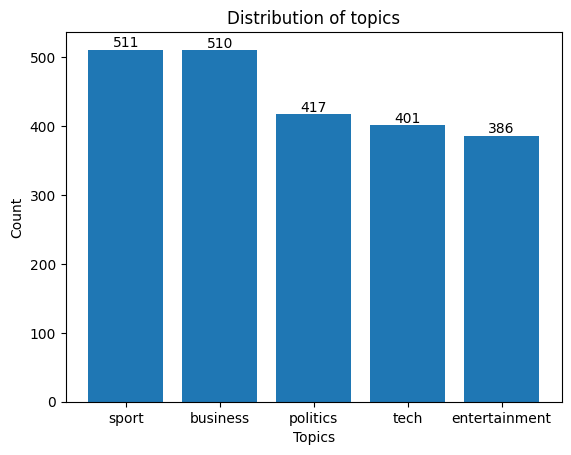

In [ ]:
# Count values of each topic
df = text_data['labels'].value_counts()

# Make a bar chart outta it
bars = plt.bar(df.index,
               df.values
              )

# Label each chart
for bar in bars:
  yval = bar.get_height()
  plt.text(bar.get_x() + bar.get_width()/2,
           yval, yval,
           ha='center',
           va='bottom')

# Signs of the chart
plt.title('Distribution of topics')
plt.ylabel('Count')
plt.xlabel('Topics');

Since the topic is not severely imbalance, I think it is not needed to pre-process against its distribution.

# Data Pre-processing

## Text cleaning and vectorizing

In [ ]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def preprocess_text(text):
    '''Preprocess text by making it lowercase, removing text in square brackets, removing links, removing punctuation, and removing words containing numbers.'''
    return re.sub('\[.*?\]|\w*\d\w*|https?://\S+|www\.\S+|<.*?>+|[%s]' % re.escape(string.punctuation), '', str(text).lower())

def eliminate_stopwords(text):
    '''Remove stopwords from the text'''
    stop_words = stopwords.words('english')
    # Tokenize words (splitting it piece by piece)
    words = text.split(' ')
    words = [word for word in words if word not in stop_words]
    return ' '.join(words)

# I skip stemming because it also filter out non-suffixes --> for example, athlete become athlet which is not contextual.
def apply_lemms(sentence):
    lemms = WordNetLemmatizer()

    # Unite the words as a compact sentence again
    return ' '.join(lemms.lemmatize(word) for word in sentence.split(' '))

def preprocess_and_clean(sentence):
    '''Preprocess and clean the text'''
    cleaned_text = preprocess_text(sentence)
    stop_words = stopwords.words('english')
    removed_stopwords_text = ' '.join(word for word in cleaned_text.split(' ') if word not in stop_words)
    lemms_text = ' '.join(apply_lemms(word) for word in removed_stopwords_text.split(' '))
    return lemms_text

In [ ]:
text_data['cleaned_text'] = text_data['data'].apply(preprocess_text)
text_data['no_stopwords'] = text_data['cleaned_text'].apply(eliminate_stopwords)
text_data['lemmatization'] = text_data['no_stopwords'].apply(apply_lemms)
text_data['final_text']   = text_data['lemmatization'].apply(preprocess_and_clean)

In [ ]:
text_data

,data,labels,cleaned_text,no_stopwords,lemmatization,final_text
0,Musicians to tackle US red tape Musicians gro...,entertainment,musicians to tackle us red tape musicians gro...,musicians tackle us red tape musicians groups...,musician tackle u red tape musician group tac...,musician tackle u red tape musician group tac...
1,"U2s desire to be number one U2, who have won ...",entertainment,desire to be number one who have won three ...,desire number one three prestigious grammy ...,desire number one three prestigious grammy ...,desire number one three prestigious grammy ...
2,Rocker Doherty in on-stage fight Rock singer ...,entertainment,rocker doherty in onstage fight rock singer p...,rocker doherty onstage fight rock singer pete...,rocker doherty onstage fight rock singer pete...,rocker doherty onstage fight rock singer pete...
3,Snicket tops US box office chart The film ada...,entertainment,snicket tops us box office chart the film ada...,snicket tops us box office chart film adaptat...,snicket top u box office chart film adaptatio...,snicket top u box office chart film adaptatio...
4,"Oceans Twelve raids box office Oceans Twelve,...",entertainment,oceans twelve raids box office oceans twelve ...,oceans twelve raids box office oceans twelve ...,ocean twelve raid box office ocean twelve cri...,ocean twelve raid box office ocean twelve cri...
...,...,...,...,...,...,...
2220,Warning over Windows Word files Writing a Mic...,tech,warning over windows word files writing a mic...,warning windows word files writing microsoft ...,warning window word file writing microsoft wo...,warning window word file writing microsoft wo...
2221,Fast lifts rise into record books Two high-sp...,tech,fast lifts rise into record books two highspe...,fast lifts rise record books two highspeed li...,fast lift rise record book two highspeed lift...,fast lift rise record book two highspeed lift...
2222,Nintendo adds media playing to DS Nintendo is...,tech,nintendo adds media playing to ds nintendo is...,nintendo adds media playing ds nintendo relea...,nintendo add medium playing d nintendo releas...,nintendo add medium playing nintendo releasin...
2223,Fast moving phone viruses appear Security fir...,tech,fast moving phone viruses appear security fir...,fast moving phone viruses appear security fir...,fast moving phone virus appear security firm ...,fast moving phone virus appear security firm ...


In [ ]:
# For simple purpose, I start to try based on TF-IDF Vectorizer
vectorizer = TfidfVectorizer()

## Modelling

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(text_data['final_text'], text_data['labels'],
                                                  test_size=0.1,
                                                  random_state=123
                                                  )

In [ ]:
vecX_train = vectorizer.fit_transform(X_train)
vecX_test  = vectorizer.transform(X_val)

In [ ]:

vecy_train = np.array(y_train)
vecy_test  = np.array(y_val)

In [ ]:
document_class1 = DecisionTreeClassifier(random_state=123)

In [ ]:
cv_score = cross_val_score(X=vecX_train,
                           y=vecy_train,
                           estimator=document_class1,
                           scoring='f1_micro',
                           cv=5
                           )

In [ ]:
print(cv_score)

[0.81795511 0.87032419 0.8425     0.8825     0.835     ]


In [ ]:
document_class1.fit(vecX_train, vecy_train)
predict = document_class1.predict(vecX_train)

In [ ]:
test_predict = document_class1.predict(vecX_test)

In [ ]:
# Evaluate on validation set
accuracy = accuracy_score(vecy_test, test_predict)
print(f"Validation Accuracy: {accuracy}")

# Detailed classification report
print(classification_report(vecy_test, test_predict))

# There are potential several problems
# 1. TF-IDF is way too simple for complicated news
# 2. Decision tree could not generalize well (I think this is the symptom, though)
# 3. Probably lemmatization is not good enough for this problem?

Validation Accuracy: 0.8968609865470852
               precision    recall  f1-score   support

     business       0.84      0.85      0.84        54
entertainment       0.88      0.85      0.87        34
     politics       0.93      0.93      0.93        43
        sport       0.92      0.97      0.94        62
         tech       0.93      0.83      0.88        30

     accuracy                           0.90       223
    macro avg       0.90      0.89      0.89       223
 weighted avg       0.90      0.90      0.90       223



If we interpret the model's metrics as one-vs-rest, here's what I got:
1. **Business**

> It has 0.84 precision. Meaning that model correctly classifies 84% of business label has "business-content". Note that 16% of the rest are necessarily not business content, however our model classifies it as a "business" (false positive).

> It has 0.85 recall. Meaning that model correctly classifies 85% "business-content" as a business label. Note that rest 15% of "business-content" arent labelled as a business label (false negative).

2. **Entertainment**

> It has 0.88 recall. Meaning that model correctly classifies 88% of entertainment label has "entertainment-content". Note that 12% of the rest are necessarily not entertainment content, however our model classifies it as a "business" (false positive).

> It has 0.85 recall. Meaning that model correctly classifies 85% "entertainment-content" as a entertainment label. Note that rest 15% of "entertainment-content" arent labelled as a entertainment label (false negative).

3. **Politics**

> It has 0.93 precision. Meaning that model correctly classifies 93% of politics label has "politics-content". Note that 7% of the rest are necessarily not politics content, however our model classifies it as a "politics" (false positive).

> It has 0.93 recall. Meaning that model correctly classifies 93% "politics-content" as a politics label. Note that rest 7% of "politics-content" arent labelled as a politics label (false negative). It is the most consistent one. Maybe it has more nuanced words, that model knows for certain it is political content.

4. **Sport**

> It has 0.92 precision. Meaning that model correctly classifies 92% of sport label has "sport-content". Note that 8% of the rest are necessarily not sport content, however our model classifies it as a "sport" (false positive).

> It has 0.97 recall. Meaning that model correctly classifies 97% "sport-content" as a sport label. Note that rest 3% of "sport-content" arent labelled as a sport label (false negative). The model knows the most what are sport content. It quickly acknowledges it. However, in precision we know that 8% of sport-label arent containing "sport-content". There are content that have sport-content terms. This is the caveat of TF-IDF feature extractor, it relies a lot on terms distribution.

5. **Tech**

> It has 0.93 precision. Meaning that model correctly classifies 93% of tech label has "tech-content". Note that 7% of the rest are necessarily not tech content, however our model classifies it as a "tech" (false positive).

> It has 0.83 recall. Meaning that model correctly classifies 83% "tech-content" as a tech label. Note that rest 17% of "tech-content" arent labelled as a tech label (false negative). I kinda get it why this happened, because tech-related content oftenly relates on business nor politics: such as The Fed rate, startups-based tech updates, global capital venture that invest to tech updates, etc.

Note that the interpretation is not entirely zero-sum game. For example, I could not accuse the lost of 7% political content are on business label.

## Test accuracy on another pre-prop
I want to test whether cleaned_text (no punctuation marks) and no stopwords-only results the same

In [ ]:
# Testing no punct-only
X_train1, X_val1, y_train1, y_val1 = train_test_split(text_data['cleaned_text'], text_data['labels'],
                                                      test_size=0.1,
                                                      random_state=123
                                                      )

In [ ]:
vecX_train1 = vectorizer.fit_transform(X_train1)
vecX_test1  = vectorizer.transform(X_val1)

In [ ]:
vecy_train1 = np.array(y_train1)
vecy_test1  = np.array(y_val1)

In [ ]:
document_class1 = DecisionTreeClassifier(random_state=123)

In [ ]:
# Cross validation
cv_score = cross_val_score(X=vecX_train1,
                           y=vecy_train1,
                           estimator=document_class1,
                           scoring='f1_micro',
                           cv=5
                           )

In [ ]:
print(cv_score)

[0.74812968 0.79052369 0.8025     0.825      0.7975    ]


In [ ]:
# Testing no stop words-only
X_train2, X_val2, y_train2, y_val2 = train_test_split(text_data['no_stopwords'], text_data['labels'],
                                                      test_size=0.1,
                                                      random_state=123
                                                      )

In [ ]:
vecX_train2 = vectorizer.fit_transform(X_train2)
vecX_test2  = vectorizer.transform(X_val2)

In [ ]:
vecX_train

<2002x26559 sparse matrix of type '<class 'numpy.float64'>'
	with 296592 stored elements in Compressed Sparse Row format>

In [ ]:
vecy_train2 = np.array(y_train2)
vecy_test2  = np.array(y_val2)

In [ ]:
cv_score = cross_val_score(X=vecX_train2,
                           y=vecy_train2,
                           estimator=document_class1,
                           scoring='f1_micro',
                           cv=5
                           )

In [ ]:
print(cv_score)

[0.77057357 0.80049875 0.8275     0.8475     0.8075    ]


Based on the cross validation scores, they confirm that cleaning text up to lemmatization is indeed a bare minimum of text-processing...

# Apply Embedding
One of most famous embeddings is Word2Vec. It has two variations: relies on skip-gram model or continuous bag of words (CBOW). It extract features within document from its corpus to evaluate their similarity (in form of vector space: evaluated by vector dot product nor cosine similarity). It is powerful for semantic meaning (capture more context rather than just relying on words distribution).

Talking about distance metrics for text:
- Dot product of two text vectors: dot product is computationally more cheap, but it accounts magnitude of vectors. Though two texts are similar, if one text has more frequency than others, it might affect the evaluation.
- Cosine similarity: while this normalize magnitudes, it is computationally more "expensive".
Source: https://datascience.stackexchange.com/questions/744/cosine-similarity-versus-dot-product-as-distance-metrics

Embeddings are strongly recommended feature-extraction before applying any deep learning structure. Because it is a dense matrix, thus channels for backprop could be found effectively.

More notes about skip-gram and CBOW:
- Both uses deep learning architecture, relatively simple one
- Skip-gram tries to predict context words given target words. CBOW tries to predict target words given context words (default algorithm).

In [ ]:
def build_corpus(data):
  corpus = []

  # data['final_text'] is a series, hence I could not do any .iteritems()
  for sentence in data['final_text']:
    # Since I wont include blank space in the corpus
    # I filter words only
    # crude .split(" ") will accrue blank space as a separate word
      word_list = [word for word in sentence.split(" ") if word]
      corpus.append(word_list)
  return corpus

In [ ]:
corpus = build_corpus(text_data)
corpus[1][0:15]

['desire',
 'number',
 'one',
 'three',
 'prestigious',
 'grammy',
 'award',
 'hit',
 'vertigo',
 'stubbornly',
 'clinging',
 'status',
 'one',
 'biggest',
 'band']

In [ ]:
# Embedding is used for training data. Soon, I will split it to learn OOV (out-of-vocab)
model = word2vec.Word2Vec(corpus,
                          vector_size=10, # Dimensionality of word
                          window=10, # How many words accounted to learn a word context
                          min_count=2, # Words with less than 2 freqs will be ignored
                          workers=4)

# Array below is a feature representation of 'hit'
model.wv['hit']

array([ 0.83815014, -3.3375576 , -0.32498214,  0.22187428,  3.0209515 ,
       -1.8358115 , -1.1694268 ,  2.826173  , -1.891367  ,  3.6616387 ],
      dtype=float32)

In [ ]:
def tsne_plot(model):
  "Creates and TSNE model and plots it"
  '''
    Since model 1 returns 10-dimension per word, we can't plot it on 2D plane.
    Thus, it needs to be simplified on to 2D, using T-SNE.
    Source: https://medium.com/swlh/word-embedding-word2vec-with-genism-nltk-and-t-sne-visualization-43eae8ab3e2e

    The author wants to understand "similarities" between words. Oftenly used to understand
    embeddings.
  '''
  labels = []
  tokens = []

  # .wv enables us to access words learned by model from the corpus
  for word in model.wv.index_to_key:
    # access that specific word from the corpus
    # and append them on tokens' list
    tokens.append(model.wv[word])
    labels.append(word)

  # Since TSNE needs to shape the array, I need to convert it to np.array instead of list
  tokens = np.array(tokens)
  tsne_model = TSNE(perplexity=40, n_components=2, init='pca',
                    max_iter=250, random_state=23)
  new_values = tsne_model.fit_transform(tokens)

  x = new_values[:, 0]
  y = new_values[:, 1]

  plt.figure(figsize=(16, 16))
  for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom'
                 )
  plt.show()
  tsne_plot(model)

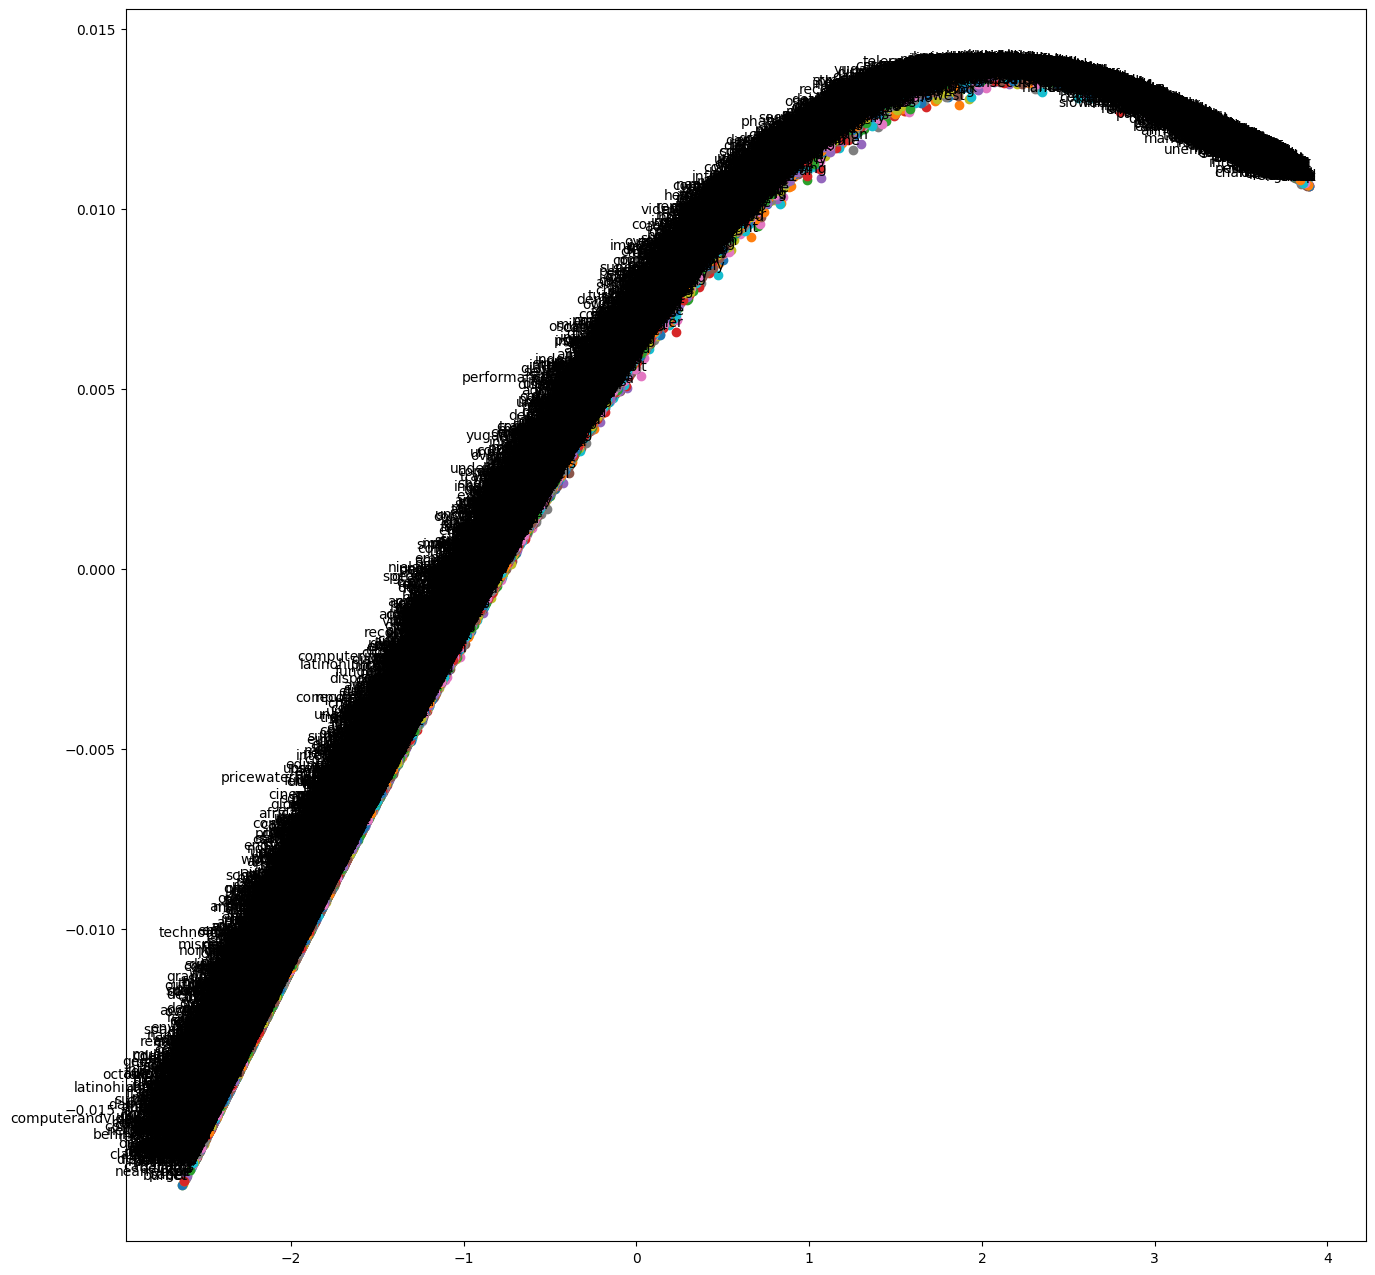

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7be3dff65ab0> (for post_execute):


KeyboardInterrupt: 

In [ ]:
# Train the model based off the corpus
model1 = word2vec.Word2Vec(corpus, vector_size=10, window=10, min_count=3, workers=4)
tsne_plot(model1)

It is surprising to see that each word forms quadratic line, instead of separate clusters. Meaning most of words have typical or overlapping features (they are interconnected).

In [ ]:
# I want to see similar words
# I need to access words learned by 'wv'
for i in ['business', 'politics', 'tech', 'sport', 'entertainment']:
  print(f'Similar words for {i.upper()}')
  similar_words = model1.wv.most_similar(i)
  for words, cos in similar_words:
    print(words)
  print('=======================\n')

# The more similar a word, the closer to 1
# The more distinct a word, the closer it is to 0 (orthogonal vector/perpendicular)
# But since our words' feature are quadratic, I don't think there are orthogonal words

Similar words for BUSINESS
pension
allowance
pay
stability
taxpayer
concern
power
undervalued
waste
risk

Similar words for POLITICS
replied
relationship
gerrard
appropriate
glad
apologise
happy
nothing
happened
family

Similar words for TECH
targeted
halt
initial
bulk
nitoglia
guideline
air
collaboration
escape
secondary

Similar words for SPORT
programme
radio
breakfast
correspondent
speculating
website
news
wgbhboston
today
directorgeneral

Similar words for ENTERTAINMENT
crack
reflection
screen
indepth
divide
mathieu
blog
joss
combine
wear



My take on the output:
1. Tech and business share similar nuance
2. Politics is the most distinct nuance
3. Entertainment and sport are also most distinct nuance, but I feel like it is a bit meaningless

Note that this word is based of text_data corpus. This likely explains why tech has less recall and entertainment is one of the lowest performance.

# Aplly LSTM
Before digging dive to LSTM ("extension" of RNN), I need to understand the distinction between traditional machine learning algorithms.

Traditional ML such us decision tree, linear regression, or else requires distinct features: often represented as a matrix. That's why TF-IDF vectorizer which is sparse feature matrix relevant for decision tree.

However, LSTM and RNN process **sequences of data** (to understand context of ```n-th``` order from ```n-1``` order). Meaning, **there is an order within a document**. Usually represented as a list, tuple, or else. Thus, TF-IDF vectorizer is not matching with LSTM and RNN architecture.

With this, embedding is the well-suited solution to match LSTM and RNN architecture. It tries to extract word's semantic context from sequence's orders. And then transformed onto dense vectors for each word. All of the dense vectors are packed up into a sequence as an input to LSTM and RNN **(vector within array)**.

https://www.kaggle.com/code/adnanzaidi/simple-lstm-for-text-classification

In [ ]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
X_train_list = X_train.tolist()  # Convert to list of strings
tok.fit_on_texts(X_train_list)
sequences = tok.texts_to_sequences(X_train_list)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

In [ ]:
sequences_matrix

array([[316,  35,  78, ..., 534,  39,  87],
       [  0,   0,   0, ...,  38, 135,   1],
       [  0,   0,   0, ..., 182,  94, 411],
       ...,
       [ 86,  27,   3, ...,  88,  96,  57],
       [  0,   0,   0, ...,   1,  48, 713],
       [  0,   0,   0, ..., 661,  38, 582]], dtype=int32)

**BIG NOTE:**

Embedding in Gensim is typically trained by simple deep learning, according to skip-gram or CBOW. It results dense vector sequence of numerical representation of each word. It is trained based on word's corpus.

While Keras' embedding initially randomize weights to help the machine represents each token. Its weights are updated during training. It is a part of Keras' neural network layer. Since it is updated automatically during training, it is not based on skip-gram nor CBOW. Each weights are updated in order to meet minimization objective. Thus, it is not having any specific algorithm of embedding: "just" part of gradient descent.

But, we can use Gensim's embedding on Keras' architecture. Since Gensim's embedding is pre-trained, I have to keep it freeze if I use it.

MODEL COMPARISON

I want to check the difference between each optimizers

In [ ]:
# SGD OPTIMIZER
# Step 1: Label Encoding (encode the y_train)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(vecy_train)

# Step 2: One-Hot Encoding
num_classes = len(label_encoder.classes_)  # Number of unique classes
y_train_one_hot = to_categorical(y_train_encoded, num_classes)

# Tokenization (tokenize the words)
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
X_train_list = X_train.tolist()  # Convert to list of strings
tok.fit_on_texts(X_train_list)
sequences = tok.texts_to_sequences(X_train_list)
sequences_matrix = sequence.pad_sequences(sequences, maxlen=max_len)

# Define the RNN model
def RNN():
    inputs = Input(name='inputs', shape=[max_len])
    layer = Embedding(max_words, 50)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256, name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(num_classes, name='out_layer')(layer)  # Set to num_classes
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs, outputs=layer)
    return model

# Instantiate and compile the model
model = RNN()
model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

# Fit the model using the one-hot encoded labels
model.fit(sequences_matrix, y_train_one_hot, batch_size=128, epochs=14,
          validation_split=0.2)

Epoch 1/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2267 - loss: 1.6092 - val_accuracy: 0.2643 - val_loss: 1.6086
Epoch 2/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2205 - loss: 1.6087 - val_accuracy: 0.2594 - val_loss: 1.6080
Epoch 3/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2461 - loss: 1.6082 - val_accuracy: 0.2668 - val_loss: 1.6073
Epoch 4/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2253 - loss: 1.6083 - val_accuracy: 0.2693 - val_loss: 1.6066
Epoch 5/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2130 - loss: 1.6075 - val_accuracy: 0.2743 - val_loss: 1.6061
Epoch 6/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2166 - loss: 1.6079 - val_accuracy: 0.2718 - val_loss: 1.6055
Epoch 7/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2224 - loss: 1.6065 - val_accuracy: 0.2718 - val_loss: 1.6050
Epoch 8/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2255 - loss: 1.6062 - val_accuracy: 0.2693 - v

In [ ]:
# ADAM OPTIMIZER
model = RNN()
model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Fit the model using the one-hot encoded labels
model.fit(sequences_matrix, y_train_one_hot, batch_size=128, epochs=14,
          validation_split=0.2)

Epoch 1/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 0.2230 - loss: 1.6069 - val_accuracy: 0.3267 - val_loss: 1.5899
Epoch 2/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4444 - loss: 1.5551 - val_accuracy: 0.5860 - val_loss: 1.2613
Epoch 3/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6121 - loss: 1.0623 - val_accuracy: 0.6908 - val_loss: 0.7360
Epoch 4/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7786 - loss: 0.6088 - val_accuracy: 0.8180 - val_loss: 0.5146
Epoch 5/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8756 - loss: 0.3610 - val_accuracy: 0.8678 - val_loss: 0.4063
Epoch 6/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9428 - loss: 0.2088 - val_accuracy: 0.9127 - val_loss: 0.3196
Epoch 7/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9705 - loss: 0.1264 - val_accuracy: 0.9227 - val_loss: 0.2763
Epoch 8/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.9872 - loss: 0.0626 - val_accuracy: 0.9277 - v

In [ ]:
# ADAMAX OPTIMIZER
model = RNN()
model.compile(loss='categorical_crossentropy', optimizer=Adamax(), metrics=['accuracy'])

# Fit the model using the one-hot encoded labels
model.fit(sequences_matrix, y_train_one_hot, batch_size=128, epochs=14,
          validation_split=0.2)

Epoch 1/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.2186 - loss: 1.6088 - val_accuracy: 0.3067 - val_loss: 1.6044
Epoch 2/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3066 - loss: 1.6038 - val_accuracy: 0.3641 - val_loss: 1.5966
Epoch 3/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3584 - loss: 1.5918 - val_accuracy: 0.4140 - val_loss: 1.5759
Epoch 4/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4217 - loss: 1.5629 - val_accuracy: 0.4688 - val_loss: 1.4938
Epoch 5/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4768 - loss: 1.4166 - val_accuracy: 0.4788 - val_loss: 1.1859
Epoch 6/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.4907 - loss: 1.1360 - val_accuracy: 0.5062 - val_loss: 1.0476
Epoch 7/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.5618 - loss: 0.9835 - val_accuracy: 0.6234 - val_loss: 0.9056
Epoch 8/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6399 - loss: 0.8783 - val_accuracy: 0.6160 - v

In [ ]:
# ADAMW OPTIMIZER
model = RNN()
model.compile(loss='categorical_crossentropy', optimizer=AdamW(), metrics=['accuracy'])

# Fit the model using the one-hot encoded labels
model.fit(sequences_matrix, y_train_one_hot, batch_size=128, epochs=14,
          validation_split=0.2)

Epoch 1/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - accuracy: 0.2492 - loss: 1.6070 - val_accuracy: 0.4090 - val_loss: 1.5900
Epoch 2/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4104 - loss: 1.5574 - val_accuracy: 0.4015 - val_loss: 1.3547
Epoch 3/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5126 - loss: 1.2562 - val_accuracy: 0.5860 - val_loss: 1.0270
Epoch 4/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6183 - loss: 0.8525 - val_accuracy: 0.7830 - val_loss: 0.5912
Epoch 5/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.8646 - loss: 0.4379 - val_accuracy: 0.8703 - val_loss: 0.5280
Epoch 6/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9180 - loss: 0.3544 - val_accuracy: 0.7880 - val_loss: 0.6017
Epoch 7/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9248 - loss: 0.2812 - val_accuracy: 0.8953 - val_loss: 0.3619
Epoch 8/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9639 - loss: 0.1592 - val_accuracy: 0.9177 - v

In [ ]:
# ADAGRAD OPTIMIZER
model = RNN()
model.compile(loss='categorical_crossentropy', optimizer=Adagrad(), metrics=['accuracy'])

# Fit the model using the one-hot encoded labels
model.fit(sequences_matrix, y_train_one_hot, batch_size=128, epochs=14,
          validation_split=0.2)

Epoch 1/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - accuracy: 0.2107 - loss: 1.6097 - val_accuracy: 0.2095 - val_loss: 1.6095
Epoch 2/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2057 - loss: 1.6093 - val_accuracy: 0.2244 - val_loss: 1.6092
Epoch 3/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2019 - loss: 1.6092 - val_accuracy: 0.2319 - val_loss: 1.6090
Epoch 4/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2427 - loss: 1.6090 - val_accuracy: 0.2294 - val_loss: 1.6088
Epoch 5/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2297 - loss: 1.6089 - val_accuracy: 0.2369 - val_loss: 1.6087
Epoch 6/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2205 - loss: 1.6088 - val_accuracy: 0.2344 - val_loss: 1.6085
Epoch 7/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2139 - loss: 1.6088 - val_accuracy: 0.2344 - val_loss: 1.6083
Epoch 8/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2244 - loss: 1.6084 - val_accuracy: 0.2344 - v

In [ ]:
# RMS PROP OPTIMIZER
model = RNN()
model.compile(loss='categorical_crossentropy', optimizer=RMSprop(), metrics=['accuracy'])

# Fit the model using the one-hot encoded labels
model.fit(sequences_matrix, y_train_one_hot, batch_size=128, epochs=14,
          validation_split=0.2)

Epoch 1/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - accuracy: 0.2236 - loss: 1.6084 - val_accuracy: 0.2594 - val_loss: 1.6020
Epoch 2/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2633 - loss: 1.6019 - val_accuracy: 0.3815 - val_loss: 1.5912
Epoch 3/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3651 - loss: 1.5850 - val_accuracy: 0.4389 - val_loss: 1.4167
Epoch 4/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4415 - loss: 1.3623 - val_accuracy: 0.4663 - val_loss: 1.1487
Epoch 5/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4580 - loss: 1.0984 - val_accuracy: 0.4813 - val_loss: 1.0160
Epoch 6/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5427 - loss: 0.9733 - val_accuracy: 0.6384 - val_loss: 0.8659
Epoch 7/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7077 - loss: 0.7655 - val_accuracy: 0.7332 - val_loss: 0.8178
Epoch 8/14
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.8071 - loss: 0.5364 - val_accuracy: 0.8479 - v

In [ ]:
test_sequences = tok.texts_to_sequences(X_val)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [ ]:
test_sequences_matrix.shape

(223, 150)

In [ ]:
vecy_test.shape

(223,)

In [ ]:
label_encoder = LabelEncoder()
y_test_encoded = label_encoder.fit_transform(vecy_test)

# Step 2: One-Hot Encoding
num_classes = len(label_encoder.classes_)  # Number of unique classes
y_test_one_hot = to_categorical(y_test_encoded, num_classes)

In [ ]:
y_test_one_hot.shape

(223, 5)

In [ ]:
# SGD
accr = model.evaluate(test_sequences_matrix, y_test_one_hot)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3148 - loss: 1.5961


In [ ]:
# ADAM
accr = model.evaluate(test_sequences_matrix, y_test_one_hot)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9768 - loss: 0.0839


In [ ]:
# ADAMAX
accr = model.evaluate(test_sequences_matrix, y_test_one_hot)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9167 - loss: 0.2845 


In [ ]:
# ADAMW
accr = model.evaluate(test_sequences_matrix, y_test_one_hot)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.9737 - loss: 0.1487 


In [ ]:
# ADAGRAD
accr = model.evaluate(test_sequences_matrix, y_test_one_hot)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2792 - loss: 1.6053 


In [ ]:
# RMS PROP
accr = model.evaluate(test_sequences_matrix, y_test_one_hot)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9417 - loss: 0.2099 


**CONCLUSION**

Amongst the best optimizer, Adam is the best one, followed by AdamW and RMS Prop. Both last two indicates overfit, however. Hence, Adam is the most well-suit for this context.

Note that the accuracy is overwhelmingly increased. Using decision tree with TF-IDF feature-extractor, it is already 89%. However, using Adam, the test accuracy overwhemingly increases to 97%!

Even though there are several problems relating to topics' nuance, LSTM with Adam helps to sky-rocket the accuracy. But, I think there is a hero without a cope here: embedding. It helps to model each word's representation feature. With combination of LSTM, it is really powerful to understand contextual and semantic relationship.

Note that I got 97% test accuracy with really fast computation. Meaning, no further complex model is needed.

# Apply to real data

In [ ]:
# I got the text sample from this: https://www.bbc.com/news/articles/c1kne7nl8vlo
real_data = "Japan PM vows to continue ruling despite bruising loss Japan's prime minister Shigeru Ishiba has vowed to continue ruling the country despite a bruising loss suffered by his party at the general election. The country now faces an uncertain political future as the coalition led by the long-ruling Liberal Democratic Party (LDP) has lost its majority in parliament, its worst result in over a decade. Ishiba was sworn in as prime minister just this month after winning the leadership of his party. He had called a snap election to seal his mandate. But in a speech on Monday, he admitted the LDP received 'severe judgement' from voters, and added his party would 'humbly accept' this. 'The Japanese people expressed their strong desire for the LDP to do some reflection and become a party that acts in line with the people's will,' Ishiba told national broadcaster NHK. The LDP and its much smaller coalition partner Komeito, have altogether taken 215 seats, falling short of the 233-seat majority needed to govern. It is the first time the LDP has lost its parliamentary majority since 2009. The party has ruled Japan almost continuously since 1955. The result comes after a tumultuous few years for the LDP which saw a cascade of scandals, widespread voter apathy and record-low approval ratings. The party had seen approval ratings of below 20% earlier in the year, in the wake of a political fundraising corruption scandal. Ishiba on Monday pledged to 'enact fundamental reform regarding the issue of money and politics'. 'We need to answer to the people’s criticism. That is how I will take responsibility for the loss of the election,' he said. He also promised to revitalise rural Japan and tackle inflation. Japan's parliament now has 30 days to convene and choose a prime minister. The chosen PM's party or coalition, will form the government and can do so even without a majority of seats. Ishiba said there are no plans to expand his political coalition at this stage. This raises the likely possibility that he will retain his premiership and his coalition will continue to rule Japan without a majority. But it also means they will no longer have the power to pass laws unilaterally. Another possibility is that the opposition parties unite to form the government - the largest one, the Constitutional Democratic Party (CDP), won 148 seats up from 98 previously. But that is a more unlikely scenario as Japan's opposition parties historically have faced difficulty in uniting or convincing voters they are a viable option to govern. The CDP had an approval rating of just 6.6% before parliament was dissolved. Japan’s politics gets a rare dose of upheaval after snap election Politics in Japan has been moving at a fast pace in recent months. Ishiba took over as the country's leader early this month following party elections held after his predecessor Fumio Kishida - who had been in the role since 2021 – made a surprise decision to step down in August. The move to call the election came at a time when the LDP is desperate to restore its tarnished image among the public. Chief among the series of scandals that have dogged the LDP is its relationship with the controversial Unification Church, described by critics as a “cult”, and the level of influence it had on lawmakers. Then came the revelations of the slush funds scandal, with dozens of LDP lawmakers accused of pocketing proceeds from political fundraising events. Those allegations, running into the millions of dollars, has led to the dissolution of powerful factions."

In [ ]:
cleaned_data = preprocess_and_clean(real_data)
cleaned_data

'japan pm vow continue ruling despite bruising loss japan prime minister shigeru ishiba vowed continue ruling country despite bruising loss suffered party general election country face uncertain political future coalition led longruling liberal democratic party ldp lost majority parliament worst result decade ishiba sworn prime minister month winning leadership party called snap election seal mandate speech monday admitted ldp received severe judgement voter added party would humbly accept japanese people expressed strong desire ldp reflection become party act line people ishiba told national broadcaster nhk ldp much smaller coalition partner komeito altogether taken  seat falling short seat majority needed govern first time ldp lost parliamentary majority since  party ruled japan almost continuously since  result come tumultuous year ldp saw cascade scandal widespread voter apathy recordlow approval rating party seen approval rating  earlier year wake political fundraising corruption 

In [ ]:
# Compare with simple LSTM structure
test_sequences_real = tok.texts_to_sequences(cleaned_data)
test_sequences_real_matrix = sequence.pad_sequences(test_sequences_real, maxlen=max_len)

# Step 2: Make Predictions
predictions = model.predict(test_sequences_real_matrix)

# Step 3: Convert Predictions to Class Labels
predicted_class_index = np.argmax(predictions, axis=1)  # Get the index of the highest probability
predicted_label = label_encoder.inverse_transform(predicted_class_index)  # Convert index back to label

print(f'This is a {predicted_label} news')

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
This is a ['sport' 'sport' 'sport' ... 'sport' 'sport' 'sport'] news


This return all of processed sequence matrix output, based off the highest probability label. Hence, we need to slice it.

In [ ]:
# Compare with simple LSTM structure
test_sequences_real = tok.texts_to_sequences(cleaned_data)
test_sequences_real_matrix = sequence.pad_sequences(test_sequences_real, maxlen=max_len)

# Step 2: Make Predictions
predictions = model.predict(test_sequences_real_matrix)

# Step 3: Convert Predictions to Class Labels
predicted_class_index = np.argmax(predictions, axis=1)  # Get the index of the highest probability
predicted_label = label_encoder.inverse_transform(predicted_class_index)  # Convert index back to label

print(f'This is a {predicted_label[1]} news')

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
This is a sport news
